# Age Prediction from High-Frequency Sleep Stage Features

This notebook evaluates whether high-frequency sleep staging captures age-related
information by training random forest regressors on sleep stage transition patterns.

## Method

1. **Load high-frequency predictions** from `predict-high-freq.py` sweep
   - Path: `logs/exp002/exp002a/sweep-*/`
   - Multiple temporal resolutions (1-3840 predictions per 30s epoch)

2. **Extract triplet features** from sleep stage sequences
   - Count occurrences of stage transition triplets (e.g., "Wake→N1→N2")
   - Features computed per 3-minute blocks during sleep
   - 80 possible triplet patterns (excluding self-transitions)

3. **Train random forest regressor** with leave-one-subject-out CV
   - 50 experiments with randomized hyperparameters (from `rnd_parameter_map_rndfcls.json`)
   - Predict subject age from triplet features

4. **Evaluate with RMSE** at each temporal resolution
   - Compare against baseline (predicting mean age)

## Data Requirements

- High-frequency prediction sweep: `logs/exp002/exp002a/sweep-*_isruc/`
- ISRUC metadata: `../final-figures/isruc-info/Details_subgroup_*_Submission.xlsx`
- Hyperparameter configs: `rnd_parameter_map_rndfcls.json`

## Output

Results (RMSE per model/resolution) are manually copied to:
- `../final-figures/hf_scores.py` → `isruc_age` dictionary

Used by `../final-figures/high-freq-panels.ipynb` for visualization.

In [1]:
import glob
import json
from functools import partial
from os.path import dirname

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def calc_mode(data, axis=0):
    bins = np.apply_along_axis(
        lambda x: np.bincount(x, minlength=5), axis=axis, arr=data
    )
    # resolve ties randomly by adding a small random number to the counts
    rand_mat = np.random.random_sample(bins.shape)
    bins = bins + rand_mat
    return np.argmax(bins, axis=axis)


usleep_isruc_path = "../../logs/exp002/exp002a/sweep-2025-07-29_18-44-18_isruc/"
usleep_isruc_labels_glob = f"{usleep_isruc_path}/*/labels.npz"
usleep_isruc_preds_glob = f"{usleep_isruc_path}/*/predictions.npz"
usleep_isruc_labels_files = sorted(glob.glob(usleep_isruc_labels_glob), key=lambda x: int(x.split("/")[-2]))
usleep_isruc_preds_files = sorted(glob.glob(usleep_isruc_preds_glob), key=lambda x: int(x.split("/")[-2]))

files_per_run_per_sr = {}
for label_file, pred_file in zip(usleep_isruc_labels_files, usleep_isruc_preds_files):
    with open(dirname(label_file) + "/predict-high-freq.log") as f:
        lines = f.readlines()
        sr_line = [line for line in lines if "sleep_stage_frequency" in line][0]
        sleep_stage_sr = int(sr_line.split("=")[1])
        model_run = [line for line in lines if "model.path=" in line][0]
        model_run = model_run.split("=")[1].strip()
    if model_run not in files_per_run_per_sr:
        files_per_run_per_sr[model_run] = {}
    files_per_run_per_sr[model_run][sleep_stage_sr] = (label_file, pred_file)

epoch_sr = 128 * 30
n_classes = 5
feature_block_duration = int(1.5 * 60 * 2)  # in epochs
possible_triplets = [f"{i}{j}{k}" for i in range(n_classes) for j in range(n_classes) for k in range(n_classes)
                     if i != j and j != k]


def calc_features(sleep_sr, pred_file, preds_per_epoch):
    features = {}
    preds_dict = np.load(pred_file)

    for rec in preds_dict.keys():
        preds = preds_dict[rec]

        sleep_start = np.where(preds_per_epoch[rec] != 0)[0][0]
        sleep_end = np.where(preds_per_epoch[rec] != 0)[0][-1]

        features[rec] = []
        for i in range(sleep_start, sleep_end, feature_block_duration):
            features[rec].append([0] * len(possible_triplets))
            features_block = preds[i * sleep_sr:min(i + feature_block_duration, sleep_end) * sleep_sr]
            features_block_1r = np.r_[features_block[0], features_block[:-1]]
            features_block_1l = np.r_[features_block[1:], features_block[-1]]

            # find triplets with a different element in the middle
            triplet_mask = np.where(((features_block - features_block_1r) != 0)
                                    & ((features_block - features_block_1l) != 0))[0]

            for trip_idx in triplet_mask:
                trip_str = f"{features_block[trip_idx - 1]}{features_block[trip_idx]}{features_block[trip_idx + 1]}"
                features[rec][-1][possible_triplets.index(trip_str)] += 1

    return features

In [2]:
metadata_files = ["../final-figures/isruc-info/Details_subgroup_I_Submission.xlsx",
                  "../final-figures/isruc-info/Details_subgroup_II_Submission.xlsx",
                  "../final-figures/isruc-info/Details_subgroup_III_Submission.xlsx"]
subj_age_dict = {}
for metadata_file in metadata_files:
    metadata = pd.read_excel(metadata_file, header=2)[["Subject", "Age"]]
    metadata = metadata[metadata["Age"].astype(str).str.isdecimal()]
    metadata["Subject"] = f"isruc-sg{len(metadata_file.split('_')[-2])}_" + metadata["Subject"].astype(str).str.replace(
        "Rec.", "")
    metadata["Age"] = metadata["Age"].astype(int)
    subj_age_dict.update(metadata.set_index("Subject")["Age"].to_dict())
subj_age_dict.update({k[:-1] + "2": v for k, v in subj_age_dict.items() if "isruc-sg2_" in k})
subj_age_dict

{'isruc-sg1_1': 64,
 'isruc-sg1_2': 52,
 'isruc-sg1_3': 38,
 'isruc-sg1_4': 27,
 'isruc-sg1_5': 58,
 'isruc-sg1_6': 22,
 'isruc-sg1_7': 70,
 'isruc-sg1_8': 76,
 'isruc-sg1_9': 61,
 'isruc-sg1_10': 53,
 'isruc-sg1_11': 80,
 'isruc-sg1_12': 79,
 'isruc-sg1_13': 65,
 'isruc-sg1_14': 66,
 'isruc-sg1_15': 52,
 'isruc-sg1_16': 50,
 'isruc-sg1_17': 79,
 'isruc-sg1_18': 38,
 'isruc-sg1_19': 59,
 'isruc-sg1_20': 59,
 'isruc-sg1_21': 72,
 'isruc-sg1_22': 85,
 'isruc-sg1_23': 50,
 'isruc-sg1_24': 65,
 'isruc-sg1_25': 29,
 'isruc-sg1_26': 69,
 'isruc-sg1_27': 26,
 'isruc-sg1_28': 62,
 'isruc-sg1_29': 42,
 'isruc-sg1_30': 51,
 'isruc-sg1_31': 29,
 'isruc-sg1_32': 65,
 'isruc-sg1_33': 32,
 'isruc-sg1_34': 43,
 'isruc-sg1_35': 59,
 'isruc-sg1_36': 36,
 'isruc-sg1_37': 52,
 'isruc-sg1_38': 37,
 'isruc-sg1_39': 66,
 'isruc-sg1_40': 62,
 'isruc-sg1_41': 66,
 'isruc-sg1_42': 67,
 'isruc-sg1_43': 44,
 'isruc-sg1_44': 46,
 'isruc-sg1_45': 60,
 'isruc-sg1_46': 28,
 'isruc-sg1_47': 65,
 'isruc-sg1_48': 23,
 

In [3]:
from sklearn.ensemble import RandomForestRegressor
from concurrent.futures import ProcessPoolExecutor


def train_and_predict(features, n_exps):
    x_data = []
    y_data = []
    subject_mapping = []

    for subject_name, subj_features in features.items():
        if subject_name not in subj_age_dict:
            print(f"No Age for {subject_name}")
            continue
        x_data.extend(subj_features)
        y_data.extend([subj_age_dict[subject_name]] * len(subj_features))
        subject_mapping.extend([subject_name] * len(subj_features))

    x_data = np.array(x_data)
    y_data = np.array(y_data)
    subject_mapping = np.array(subject_mapping)

    label_age = []
    predict_age = []
    for run_num in range(n_exps):
        label_age.append([])
        predict_age.append([])

        with ProcessPoolExecutor(max_workers=32) as executor:
            partial_f = partial(fit_and_predict, run_num, x_data, y_data, subject_mapping)
            results = list(executor.map(partial_f, np.unique(subject_mapping)))
            for label, pred in results:
                label_age[-1].append(label)
                predict_age[-1].append(pred)

    return label_age, predict_age


with open("rnd_parameter_map_rndfcls.json", "r") as f:
    rnd_parameter_map = json.load(f)


def fit_and_predict(run_num, x_data, y_data, subject_mapping, subj):
    x_train = x_data[subject_mapping != subj].copy()
    y_train = y_data[subject_mapping != subj].copy()
    x_test = x_data[subject_mapping == subj].copy()
    y_test = y_data[subject_mapping == subj].copy()

    clf = RandomForestRegressor(n_estimators=200,
                                max_depth=rnd_parameter_map[run_num]["max_tree_depth"],
                                min_samples_leaf=rnd_parameter_map[run_num]["min_samples_leaf"],
                                min_samples_split=rnd_parameter_map[run_num]["min_samples_split"],
                                max_features=rnd_parameter_map[run_num]["max_features"])
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    return y_test[0], np.mean(y_pred)

In [4]:
from sklearn.metrics import root_mean_squared_error

n_exps = 50

rmses = {}
for model_run, files_per_sr in files_per_run_per_sr.items():
    print(f"Model epoch: {model_run}")
    preds_per_epoch = np.load(files_per_sr[1][1])
    rmses[model_run] = {}
    for sleep_stage_sr, files in files_per_sr.items():
        features = calc_features(sleep_stage_sr, files[1], preds_per_epoch)
        label_age, predict_age = train_and_predict(features, n_exps)

        predict_age = np.array(predict_age)
        label_age = np.array(label_age)

        predict_age_bin = (predict_age > 0.5).astype(int)
        predict_age_bin[predict_age == 0.5] = np.random.randint(0, 2, size=np.sum(predict_age == 0.5))

        rmse_array = []
        for i_exp in range(n_exps):
            rmse = root_mean_squared_error(label_age[i_exp], predict_age[i_exp])
            rmse_array.append(rmse)

        print(f"{sleep_stage_sr} sleep stages per epoch")
        print(f"Avg. RMSE: {np.mean(rmse_array)}")
        print(f"Std. RMSE: {np.std(rmse_array)}")
        print()
        rmses[model_run][sleep_stage_sr] = rmse_array


Model epoch: griegeru_hs40.pth
No Age for isruc-sg1_86
No Age for isruc-sg1_95


1 sleep stages per epoch
Avg. RMSE: 15.727044268820368
Std. RMSE: 0.14491980675900604

No Age for isruc-sg1_86
No Age for isruc-sg1_95


2 sleep stages per epoch
Avg. RMSE: 15.397641386463397
Std. RMSE: 0.22444184249318588

No Age for isruc-sg1_86
No Age for isruc-sg1_95


4 sleep stages per epoch
Avg. RMSE: 15.02062315268692
Std. RMSE: 0.29636431662392254

No Age for isruc-sg1_86
No Age for isruc-sg1_95


8 sleep stages per epoch
Avg. RMSE: 14.77909975647617
Std. RMSE: 0.32856895236278755



No Age for isruc-sg1_86
No Age for isruc-sg1_95


16 sleep stages per epoch
Avg. RMSE: 14.457546988000269
Std. RMSE: 0.33108428893916625



No Age for isruc-sg1_86
No Age for isruc-sg1_95


32 sleep stages per epoch
Avg. RMSE: 14.47374439091227
Std. RMSE: 0.2810545332927036



No Age for isruc-sg1_86
No Age for isruc-sg1_95


64 sleep stages per epoch
Avg. RMSE: 14.443357977565258
Std. RMSE: 0.32205251770400456



No Age for isruc-sg1_86
No Age for isruc-sg1_95


128 sleep stages per epoch
Avg. RMSE: 14.35986697469758
Std. RMSE: 0.3770201436071604



No Age for isruc-sg1_86
No Age for isruc-sg1_95


256 sleep stages per epoch
Avg. RMSE: 14.380531927413433
Std. RMSE: 0.40528843748807475



No Age for isruc-sg1_86
No Age for isruc-sg1_95


384 sleep stages per epoch
Avg. RMSE: 14.313410777019273
Std. RMSE: 0.41930160132645217



No Age for isruc-sg1_86
No Age for isruc-sg1_95


640 sleep stages per epoch
Avg. RMSE: 14.333858402611236
Std. RMSE: 0.4474262798307171



No Age for isruc-sg1_86
No Age for isruc-sg1_95


960 sleep stages per epoch
Avg. RMSE: 14.487192471295813
Std. RMSE: 0.4996601190601808



No Age for isruc-sg1_86
No Age for isruc-sg1_95


1920 sleep stages per epoch
Avg. RMSE: 14.740992901014515
Std. RMSE: 0.4833725689251681



No Age for isruc-sg1_86
No Age for isruc-sg1_95


3840 sleep stages per epoch
Avg. RMSE: 14.938071474321632
Std. RMSE: 0.49632136771774377

Model epoch: train-usleep-2025-07-21_12-03-51-final.pth
No Age for isruc-sg1_86
No Age for isruc-sg1_95


1 sleep stages per epoch
Avg. RMSE: 15.50305697678098
Std. RMSE: 0.1908617026490254

No Age for isruc-sg1_86
No Age for isruc-sg1_95


2 sleep stages per epoch
Avg. RMSE: 15.271049435856826
Std. RMSE: 0.2533001623579229

No Age for isruc-sg1_86
No Age for isruc-sg1_95


4 sleep stages per epoch
Avg. RMSE: 14.967619342978706
Std. RMSE: 0.29250858929230006

No Age for isruc-sg1_86
No Age for isruc-sg1_95


8 sleep stages per epoch
Avg. RMSE: 14.55684413345942
Std. RMSE: 0.3771326115742355



No Age for isruc-sg1_86
No Age for isruc-sg1_95


16 sleep stages per epoch
Avg. RMSE: 14.524175732258428
Std. RMSE: 0.3653564040199386



No Age for isruc-sg1_86
No Age for isruc-sg1_95


32 sleep stages per epoch
Avg. RMSE: 13.927859695956792
Std. RMSE: 0.42640712696591804



No Age for isruc-sg1_86
No Age for isruc-sg1_95


64 sleep stages per epoch
Avg. RMSE: 13.626983854821274
Std. RMSE: 0.4274874602101429



No Age for isruc-sg1_86
No Age for isruc-sg1_95


128 sleep stages per epoch
Avg. RMSE: 13.647857334295288
Std. RMSE: 0.43702895490215526



No Age for isruc-sg1_86
No Age for isruc-sg1_95


256 sleep stages per epoch
Avg. RMSE: 13.786547821073668
Std. RMSE: 0.43007914157623756



No Age for isruc-sg1_86
No Age for isruc-sg1_95


384 sleep stages per epoch
Avg. RMSE: 13.667718155796813
Std. RMSE: 0.43963224046498195



No Age for isruc-sg1_86
No Age for isruc-sg1_95


640 sleep stages per epoch
Avg. RMSE: 13.847072843328437
Std. RMSE: 0.4186345759280932



No Age for isruc-sg1_86
No Age for isruc-sg1_95


960 sleep stages per epoch
Avg. RMSE: 14.044262688503345
Std. RMSE: 0.39833853492277643



No Age for isruc-sg1_86
No Age for isruc-sg1_95


1920 sleep stages per epoch
Avg. RMSE: 14.080882247599401
Std. RMSE: 0.4214839216903983



No Age for isruc-sg1_86
No Age for isruc-sg1_95


3840 sleep stages per epoch
Avg. RMSE: 14.076018453316365
Std. RMSE: 0.4548496558751973

Model epoch: train-usleep-2025-07-21_12-04-20-final.pth
No Age for isruc-sg1_86
No Age for isruc-sg1_95


1 sleep stages per epoch
Avg. RMSE: 15.684818671035016
Std. RMSE: 0.15167434066454805

No Age for isruc-sg1_86
No Age for isruc-sg1_95


2 sleep stages per epoch
Avg. RMSE: 15.156735950430908
Std. RMSE: 0.27137494270300566

No Age for isruc-sg1_86
No Age for isruc-sg1_95


4 sleep stages per epoch
Avg. RMSE: 15.167577572060447
Std. RMSE: 0.26243423057671034

No Age for isruc-sg1_86
No Age for isruc-sg1_95


8 sleep stages per epoch
Avg. RMSE: 15.060183842030453
Std. RMSE: 0.25503789059868026



No Age for isruc-sg1_86
No Age for isruc-sg1_95


16 sleep stages per epoch
Avg. RMSE: 14.461775939257118
Std. RMSE: 0.3680205084856411



No Age for isruc-sg1_86
No Age for isruc-sg1_95


32 sleep stages per epoch
Avg. RMSE: 14.412584354101273
Std. RMSE: 0.33973539507195816



No Age for isruc-sg1_86
No Age for isruc-sg1_95


64 sleep stages per epoch
Avg. RMSE: 14.114927851714107
Std. RMSE: 0.3932445463065903



No Age for isruc-sg1_86
No Age for isruc-sg1_95


128 sleep stages per epoch
Avg. RMSE: 14.13197036606686
Std. RMSE: 0.41918152391275404



No Age for isruc-sg1_86
No Age for isruc-sg1_95


256 sleep stages per epoch
Avg. RMSE: 14.270244902857126
Std. RMSE: 0.39368101958860124



No Age for isruc-sg1_86
No Age for isruc-sg1_95


384 sleep stages per epoch
Avg. RMSE: 14.4278623530195
Std. RMSE: 0.37014473788413577



No Age for isruc-sg1_86
No Age for isruc-sg1_95


640 sleep stages per epoch
Avg. RMSE: 14.49036977716109
Std. RMSE: 0.3842460460655219



No Age for isruc-sg1_86
No Age for isruc-sg1_95


960 sleep stages per epoch
Avg. RMSE: 14.458830850014486
Std. RMSE: 0.418716776608167



No Age for isruc-sg1_86
No Age for isruc-sg1_95


1920 sleep stages per epoch
Avg. RMSE: 14.690305716002714
Std. RMSE: 0.4694060774463668



No Age for isruc-sg1_86
No Age for isruc-sg1_95


3840 sleep stages per epoch
Avg. RMSE: 14.525829288182898
Std. RMSE: 0.4719760844334058

Model epoch: train-usleep-2025-07-21_12-04-54-final.pth
No Age for isruc-sg1_86
No Age for isruc-sg1_95


1 sleep stages per epoch
Avg. RMSE: 15.697827647063418
Std. RMSE: 0.1539897587617738

No Age for isruc-sg1_86
No Age for isruc-sg1_95


2 sleep stages per epoch
Avg. RMSE: 15.18809667116431
Std. RMSE: 0.26749099241372765

No Age for isruc-sg1_86
No Age for isruc-sg1_95


4 sleep stages per epoch
Avg. RMSE: 15.030747858292548
Std. RMSE: 0.30680582150783897

No Age for isruc-sg1_86
No Age for isruc-sg1_95


8 sleep stages per epoch
Avg. RMSE: 14.808174891316591
Std. RMSE: 0.3334359819633187



No Age for isruc-sg1_86
No Age for isruc-sg1_95


16 sleep stages per epoch
Avg. RMSE: 14.66277683102094
Std. RMSE: 0.3855195591055278



No Age for isruc-sg1_86
No Age for isruc-sg1_95


32 sleep stages per epoch
Avg. RMSE: 14.368465285707087
Std. RMSE: 0.42011692715555515



No Age for isruc-sg1_86
No Age for isruc-sg1_95


64 sleep stages per epoch
Avg. RMSE: 14.01310539239033
Std. RMSE: 0.45375414398331065



No Age for isruc-sg1_86
No Age for isruc-sg1_95


128 sleep stages per epoch
Avg. RMSE: 13.835975848469099
Std. RMSE: 0.43546253214625996



No Age for isruc-sg1_86
No Age for isruc-sg1_95


256 sleep stages per epoch
Avg. RMSE: 13.792094773951929
Std. RMSE: 0.4408203611655784



No Age for isruc-sg1_86
No Age for isruc-sg1_95


384 sleep stages per epoch
Avg. RMSE: 13.76478865067985
Std. RMSE: 0.44365863393579463



No Age for isruc-sg1_86
No Age for isruc-sg1_95


640 sleep stages per epoch
Avg. RMSE: 13.733239605749059
Std. RMSE: 0.4326182696124011



No Age for isruc-sg1_86
No Age for isruc-sg1_95


960 sleep stages per epoch
Avg. RMSE: 13.889768622392744
Std. RMSE: 0.45997349168588386



No Age for isruc-sg1_86
No Age for isruc-sg1_95


1920 sleep stages per epoch
Avg. RMSE: 14.295255521488189
Std. RMSE: 0.43442620020394723



No Age for isruc-sg1_86
No Age for isruc-sg1_95


3840 sleep stages per epoch
Avg. RMSE: 14.459176451493152
Std. RMSE: 0.42681442871867603



In [5]:
print(rmses)

{'griegeru_hs40.pth': {1: [15.637728450606991, 15.70655959676938, 15.921521608647193, 15.616133233063659, 15.919593628483952, 15.711269924537017, 15.961350959181939, 15.589488548059567, 15.74038146445625, 15.680923915825417, 15.682678740340817, 15.699465147590988, 15.735992062385085, 15.701323290811228, 15.884520504518122, 15.883354168267104, 15.569895125939306, 15.957249900204944, 15.799057056691481, 15.62217069282193, 15.694048347477983, 15.541522053923266, 15.682948091224118, 15.928561733386545, 15.95469330607098, 15.634867731655975, 15.653159447218806, 15.800938565810403, 15.498768281801153, 15.588106607575172, 15.425961666872443, 15.611344457976887, 15.805849405483842, 15.79369234332055, 15.466963190049993, 15.65829662468197, 15.664960165111026, 15.879000324634573, 15.51354849198494, 15.91384654746463, 15.930345533135112, 15.875890583684336, 15.61601704429844, 15.721340144666625, 15.613154896510247, 15.66000693187352, 15.965029260605505, 15.619468224277437, 15.95312621845408, 15.6

In [6]:
# add a baseline predicting the mean
preds = []
labels = []
for subject_name in subj_age_dict.keys():
    preds.append(np.mean(list(subj_age_dict.values())))
    labels.append(subj_age_dict[subject_name])

rmse_base = root_mean_squared_error(labels, preds)

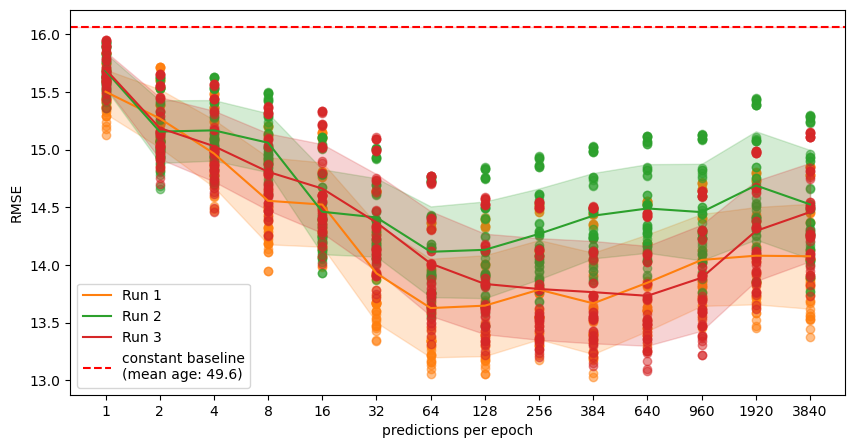

In [7]:
plt.figure(figsize=(10, 5))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
for i, (model_run, rmses_epoch) in enumerate(rmses.items()):
    if model_run == "griegeru_hs40.pth":
        continue
    c = colors[i % len(colors)]
    means_to_plot = np.array(list(rmses_epoch.values())).mean(axis=1)
    stds_to_plot = np.array(list(rmses_epoch.values())).std(axis=1)
    plt.plot(range(len(rmses_epoch)), means_to_plot, label=f"Run {i}", color=c)
    plt.fill_between(range(len(rmses_epoch)), means_to_plot - stds_to_plot, means_to_plot + stds_to_plot,
                     alpha=0.2, color=c)
    plt.scatter(np.repeat(range(len(rmses_epoch)), n_exps), np.array(list(rmses_epoch.values())).flatten(),
                alpha=0.5, color=c)

x_low_lim, x_high_lim = plt.xlim()
plt.axhline(np.mean(rmse_base), ls="--", c="r", label=f"constant baseline\n(mean age: {np.mean(preds):.1f})")
# plt.axhline(np.mean(rmse_base) - np.std(rmse_base), ls="--", c="r", alpha=0.5)
# plt.axhline(np.mean(rmse_base) + np.std(rmse_base), ls="--", c="r", alpha=0.5)
plt.fill_between([x_low_lim, x_high_lim], np.mean(rmse_base) - np.std(rmse_base),
                 np.mean(rmse_base) + np.std(rmse_base), alpha=0.2, color="r")

first_key = next(iter(rmses))
plt.xticks(range(len(rmses[first_key])), list(rmses[first_key].keys()))
# plt.grid()
plt.xlim([x_low_lim, x_high_lim])
plt.xlabel("predictions per epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()